In [8]:
import scipy.io
import tensorflow as tf
import keras
from numpy import array


from keras.preprocessing.sequence import TimeseriesGenerator


#build Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as ms
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

# Preprocessing

In [9]:
def load_trainD(path):
  mat_train = scipy.io.loadmat(train_file_path) 
  train_data = mat_train['Xtrain']
  trai_test_vec = train_data[:,0]
  return trai_test_vec

def load_testD(path):
  mat_test = scipy.io.loadmat(test_file_path)
  test_data = mat_test['Xtest'] 
  test_test_vec = test_data[:,0]
  return test_test_vec

def rescale_data(train_data,test_data):
  train_data = train_data/255
  test_data = test_data/255
  return train_data,test_data

def create_data_mat(data, depth=10):
  dmatrix = np.zeros((len(data), int(depth)))
  #print(dmatrix.shape)
  for i in range(len(data)-depth) :
    selcted_range = data[i:i+depth]
    #print(selcted_range.shape)
    dmatrix[i] = selcted_range
  return dmatrix

def split_Xy(dataset):
  y = dataset[:, -1] # for last column
  X = dataset[:, :-1] # for all but last column
  return X,y

def split_validation(dataset,p):
  t=dataset[:p]
  v=dataset[p:]
  return t,v

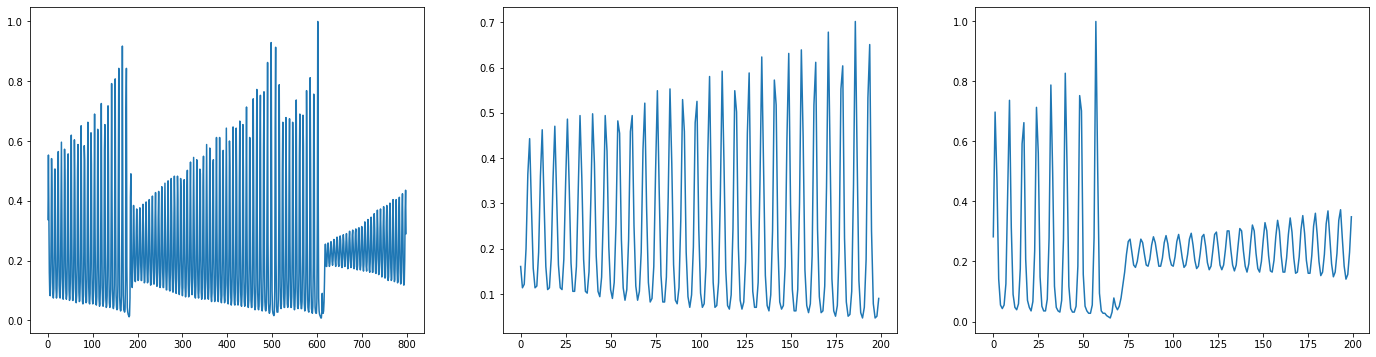

In [10]:
train_file_path = '/content/drive/MyDrive/Master_AI/Xtrain.mat' #@param {type:"string"}
test_file_path = '/content/drive/MyDrive/Master_AI/Xtest-1.mat' #@param {type:"string"}

to_rescale = True #@param {type:"boolean"}

valid_split_point = 800 #@param {type:"slider", min:0, max:1000, step:1}

for_Regerssion = False #@param {type:"boolean"}

train_data = load_trainD(train_file_path)
test_data = load_testD(test_file_path)

if(to_rescale):
  train_data,test_data = rescale_data(train_data,test_data)

train_data, valid_data = split_validation(train_data,800)

if(for_Regerssion):
  TrainMatrix = create_data_mat(train_data)
  X_train,y_train = split_Xy(TrainMatrix)

  TestMatrix = create_data_mat(test_data)
  X_test,y_test = split_Xy(TestMatrix)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24, 6))
ax1.plot(train_data)
ax2.plot(valid_data)
ax3.plot(test_data)


# Liniear Regession (no Deep Learning)

In [ ]:
def LogReg(X_train,y_train):
  lr_model = LogisticRegression(max_iter=100, solver='liblinear')
  lr_model.fit(X_train, y_train);
  return lr_model

lr_model = LogReg(X_train,y_train)

Logistic Regression Accuracy: 0.164


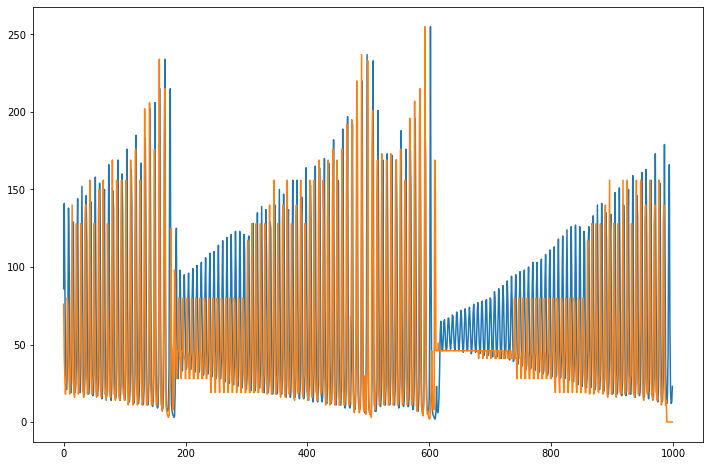

In [ ]:
lr_pred_val = lr_model.predict(X_train)
lr_pred_acc = metrics.accuracy_score(y_train, lr_pred_val)
print('Logistic Regression Accuracy: {}'.format(lr_pred_acc))
fig = plt.figure(figsize=(12, 8))
plt.plot(trai_test_vec)
plt.plot(lr_pred_val)

Logistic Regression Accuracy: 0.095


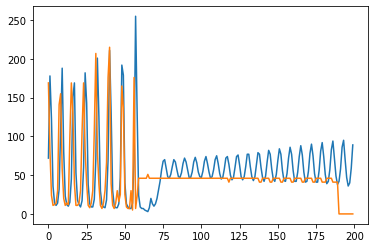

In [ ]:
lr_pred_val = lr_model.predict(X_test)
lr_pred_acc = metrics.accuracy_score(y_test, lr_pred_val)
print('Logistic Regression Accuracy: {}'.format(lr_pred_acc))

plt.plot(test_test_vec)
plt.plot(lr_pred_val)

# Deep Learning Models / Neural Network Models
The following Models are build with Tensorflow.

In [11]:



def compile_model(model):
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=['mse',tf.keras.metrics.RootMeanSquaredError(),'mae'])
                #metrics=[tf.metrics.MeanAbsoluteError()])
  return model
def fit_model(model,train,validation,patience=2):

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validation,
                      callbacks=[early_stopping])
  return history
def validate_model(model,history,train,validation,test):
  predict_train = model.predict(train, verbose=0)
  predict_valid = model.predict(validation, verbose=0)
  predict_test  = model.predict(test, verbose=0)

  delta_train = np.absolute(predict_train[:,0]-train_data[n_input:])
  delta_valid = np.absolute(predict_valid[:,0] - valid_data[n_input:])
  delta_test = np.absolute(predict_test[:,0] - test_data[n_input:])

  fig, axs = plt.subplots(3, 3,figsize=(24,12), gridspec_kw={'height_ratios': [2, 1, 2]})
  axs[0,0].set_title('Train Data Prediction')
  axs[0,0].plot(train_data[n_input:])
  axs[0,0].plot(predict_train)
  axs[0,1].set_title('Validation Data Prediction')
  axs[0,1].plot(valid_data[n_input:])
  axs[0,1].plot(predict_valid)
  axs[0,2].set_title('Test Data Prediction')
  axs[0,2].plot(test_data[n_input:])
  axs[0,2].plot(predict_test)

  axs[1,0].set_title('Prediction Error per Prediction (Train Data)')
  axs[1,0].set(ylim=(0.0, 1.0))
  axs[1,0].plot(delta_train)
  axs[1,1].set_title('Prediction Error per Prediction (Validation Data)')
  axs[1,1].set(ylim=(0.0, 1.0))
  axs[1,1].plot(delta_valid)
  axs[1,2].set_title('Prediction Error per Prediction (Test Data)')
  axs[1,2].set(ylim=(0.0, 1.0))
  axs[1,2].plot(delta_test)

  axs[2,0].set_title('MSE')
  axs[2,0].plot(history.history['mse'])
  axs[2,0].plot(history.history['val_mse'])
  axs[2,1].set_title('RMSE')
  axs[2,1].plot(history.history['root_mean_squared_error'])
  axs[2,1].plot(history.history['val_root_mean_squared_error'])
  axs[2,2].set_title('MAE')
  axs[2,2].plot(history.history['mae'])
  axs[2,2].plot(history.history['val_mae'])
  plt.show()

  results = model.evaluate(test)
  print(results)

  return

def recursiv_prediction(model, data, control_data, data_length=20, prediction_length=200):

  prediction = np.zeros(prediction_length)
  train_data=control_data
  temp_predict_data = data
  for i in range(prediction_length):
    recursiv_predict = model.predict(temp_predict_data, verbose=0)
    prediction[i]=recursiv_predict[0,0]
    temp_predict_data = np.roll(temp_predict_data,-1)
    temp_predict_data[0,-1] = recursiv_predict

  fig, ax = plt.subplots(figsize=(24, 6))
  ax.plot(train_data[data_length:(200+data_length)])
  ax.plot(prediction)

  return prediction

# Linear Model

In [13]:
n_features = 1 #
n_input = 50 #@param {type:"slider", min:0, max:100, step:1}
b_size = 30 #@param {type:"slider", min:0, max:100, step:1}

MAX_EPOCHS = 200  #@param {type:"slider", min:0, max:200, step:1}

patience = 10  #@param {type:"slider", min:0, max:100, step:1}

ts_train = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=b_size)
ts_valid = TimeseriesGenerator(valid_data, valid_data, length=n_input, batch_size=b_size)

sl_dense_model = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

sl_dense_model = compile_model(sl_dense_model)
log_sl_dense_model = fit_model(sl_dense_model,ts_train,ts_valid,patience)

Epoch 1/200
25/25 [==============================] - 1s 10ms/step - loss: 0.0580 - mse: 0.0580 - root_mean_squared_error: 0.2409 - mae: 0.1723 - val_loss: 0.0314 - val_mse: 0.0314 - val_root_mean_squared_error: 0.1773 - val_mae: 0.1487
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0465 - mse: 0.0465 - root_mean_squared_error: 0.2156 - mae: 0.1539 - val_loss: 0.0235 - val_mse: 0.0235 - val_root_mean_squared_error: 0.1534 - val_mae: 0.1248
Epoch 3/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0420 - mse: 0.0420 - root_mean_squared_error: 0.2049 - mae: 0.1428 - val_loss: 0.0198 - val_mse: 0.0198 - val_root_mean_squared_error: 0.1406 - val_mae: 0.1146
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0387 - mse: 0.0387 - root_mean_squared_error: 0.1968 - mae: 0.1354 - val_loss: 0.0169 - val_mse: 0.0169 - val_root_mean_squared_error: 0.1301 - val_mae: 0.1065
Epoch 5/200
25/25 [==============================] - 0s 5ms

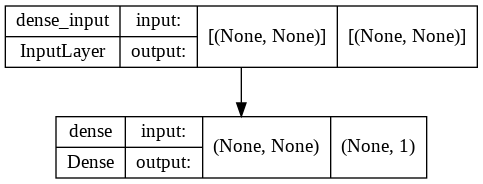

In [21]:
plot_model(sl_dense_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

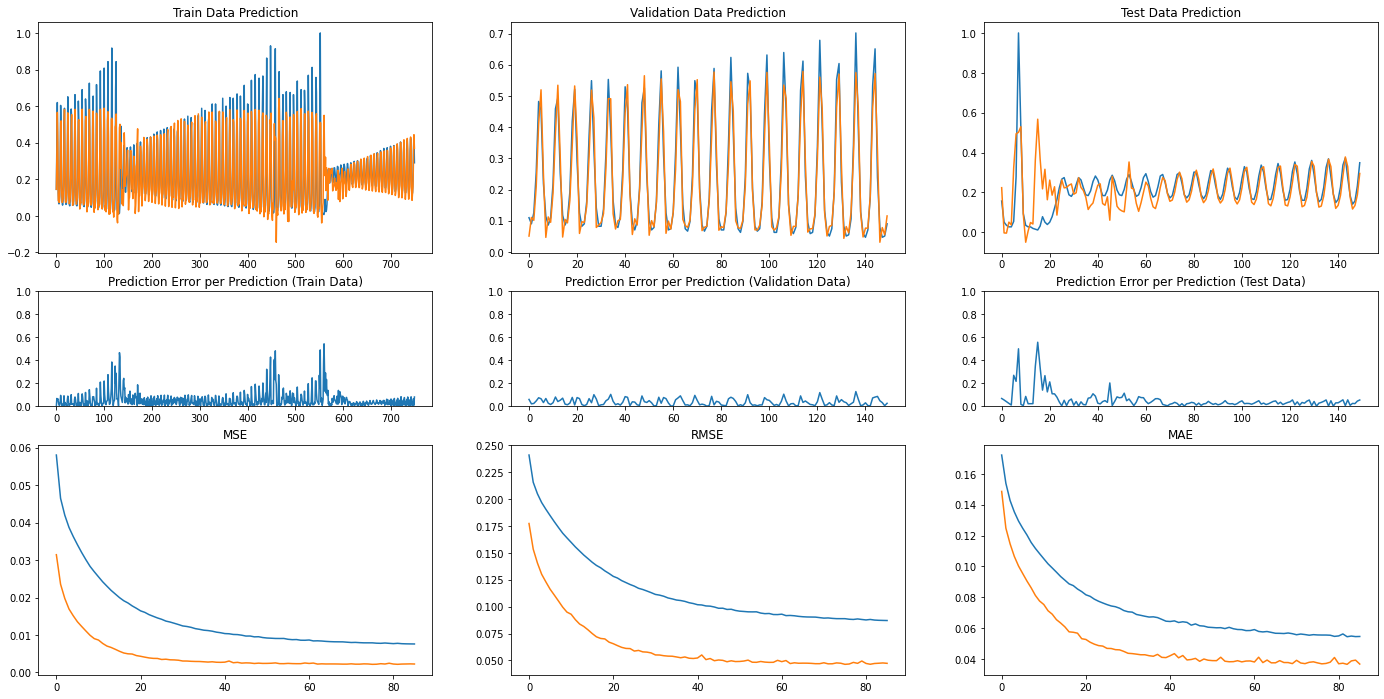

5/5 [==============================] - 0s 4ms/step - loss: 0.0090 - mse: 0.0090 - root_mean_squared_error: 0.0948 - mae: 0.0533
[0.008995985612273216, 0.008995985612273216, 0.094847172498703, 0.05325416103005409]


In [14]:
ts_test = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=b_size)
validate_model(sl_dense_model,log_sl_dense_model,ts_train,ts_valid,ts_test)

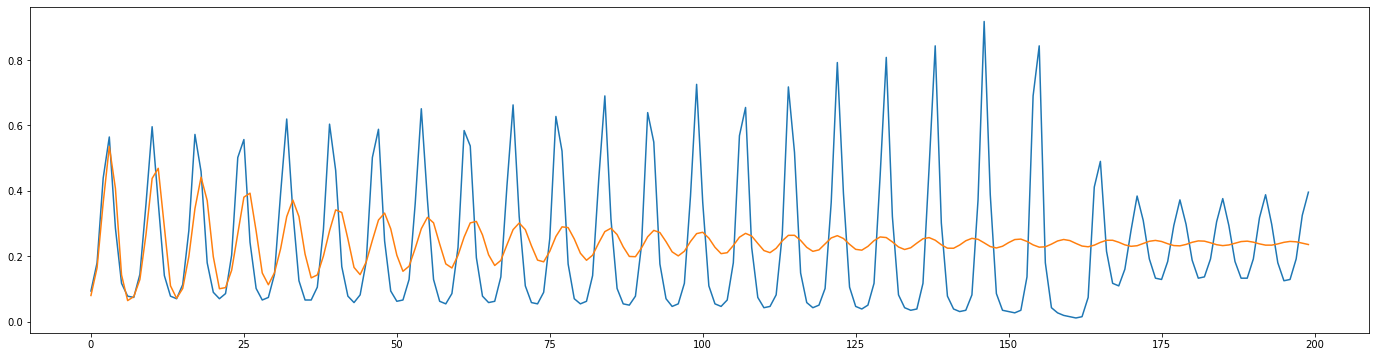

In [82]:

rec_prediction = recursiv_prediction(sl_dense_model,ts_train[0][0][0].reshape(1,20),control_data=train_data,data_length=20)


#Multi Dense Model

In [19]:
n_features = 1 #
n_input = 50 #@param {type:"slider", min:0, max:100, step:1}
b_size = 30 #@param {type:"slider", min:0, max:100, step:1}

MAX_EPOCHS = 100  #@param {type:"slider", min:0, max:100, step:1}

patience = 10  #@param {type:"slider", min:0, max:100, step:1}

ts_train = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=b_size)
ts_valid = TimeseriesGenerator(valid_data, valid_data, length=n_input, batch_size=b_size)

ml_dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

ml_dense_model = compile_model(ml_dense_model)
log_ml_dense_model = fit_model(ml_dense_model,ts_train,ts_valid,patience)





Epoch 1/100
25/25 [==============================] - 1s 12ms/step - loss: 0.0305 - mse: 0.0305 - root_mean_squared_error: 0.1747 - mae: 0.1330 - val_loss: 0.0069 - val_mse: 0.0069 - val_root_mean_squared_error: 0.0830 - val_mae: 0.0676
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0203 - mse: 0.0203 - root_mean_squared_error: 0.1423 - mae: 0.1019 - val_loss: 0.0063 - val_mse: 0.0063 - val_root_mean_squared_error: 0.0795 - val_mae: 0.0623
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0166 - mse: 0.0166 - root_mean_squared_error: 0.1289 - mae: 0.0906 - val_loss: 0.0045 - val_mse: 0.0045 - val_root_mean_squared_error: 0.0670 - val_mae: 0.0525
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0144 - mse: 0.0144 - root_mean_squared_error: 0.1202 - mae: 0.0833 - val_loss: 0.0038 - val_mse: 0.0038 - val_root_mean_squared_error: 0.0616 - val_mae: 0.0487
Epoch 5/100
25/25 [==============================] - 0s 5ms

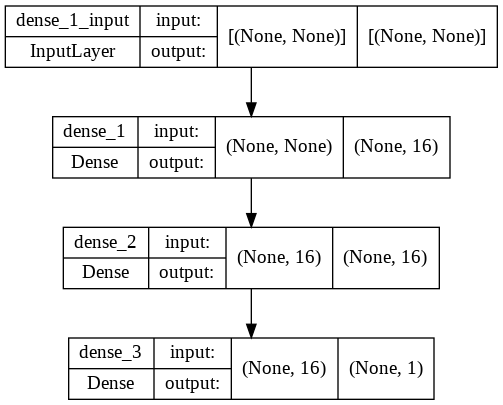

In [23]:
plot_model(ml_dense_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

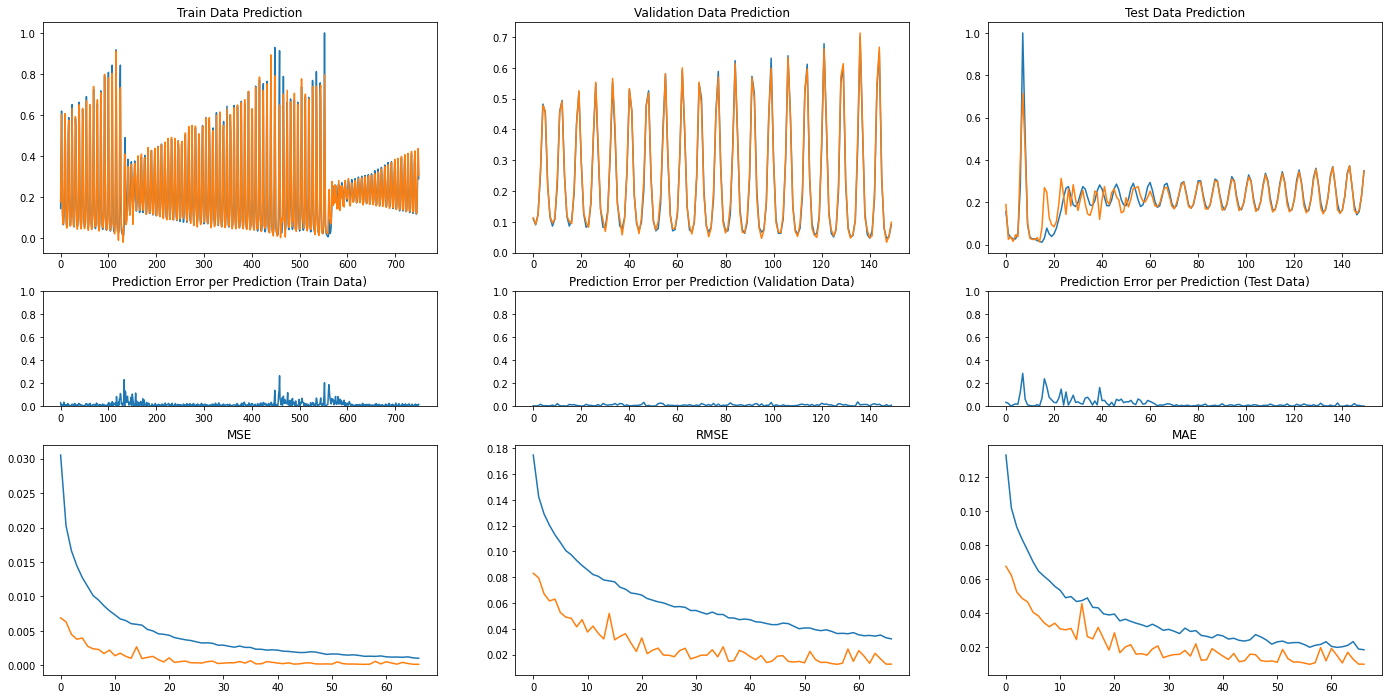

5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - root_mean_squared_error: 0.0483 - mae: 0.0257
[0.002333391224965453, 0.002333391224965453, 0.04830518737435341, 0.025740759447216988]


In [20]:
ts_test = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=b_size)
validate_model(ml_dense_model,log_dense,ts_train,ts_valid,ts_test)

# **RNN/LSTM**

In [42]:
n_features = 1 #
n_input = 15 #@param {type:"slider", min:0, max:100, step:1}
b_size = 25 #@param {type:"slider", min:0, max:100, step:1}

MAX_EPOCHS = 100  #@param {type:"slider", min:0, max:100, step:1}

patience = 10  #@param {type:"slider", min:0, max:100, step:1}

t2 = train_data.reshape(800,1)
v2 = valid_data.reshape(200,1)

ts_train = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)
ts_valid = TimeseriesGenerator(v2, v2, length=n_input, batch_size=b_size)

#ts_train = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=b_size)
#ts_valid = TimeseriesGenerator(valid_data, valid_data, length=n_input, batch_size=b_size)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

#lstm_model = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

lstm_model = compile_model(lstm_model)
log_lstm_model = fit_model(lstm_model,ts_train,ts_valid,patience)

Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.0404 - mse: 0.0404 - root_mean_squared_error: 0.2010 - mae: 0.1471 - val_loss: 0.0249 - val_mse: 0.0249 - val_root_mean_squared_error: 0.1578 - val_mae: 0.1278
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0276 - mse: 0.0276 - root_mean_squared_error: 0.1660 - mae: 0.1253 - val_loss: 0.0174 - val_mse: 0.0174 - val_root_mean_squared_error: 0.1321 - val_mae: 0.1096
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0207 - mse: 0.0207 - root_mean_squared_error: 0.1438 - mae: 0.1048 - val_loss: 0.0102 - val_mse: 0.0102 - val_root_mean_squared_error: 0.1008 - val_mae: 0.0847
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0154 - mse: 0.0154 - root_mean_squared_error: 0.1241 - mae: 0.0838 - val_loss: 0.0067 - val_mse: 0.0067 - val_root_mean_squared_error: 0.0820 - val_mae: 0.0620
Epoch 5/100
32/32 [==============================] - 0s 

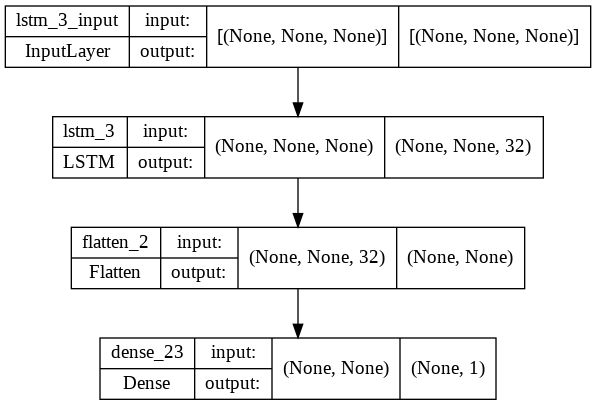

In [35]:
plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

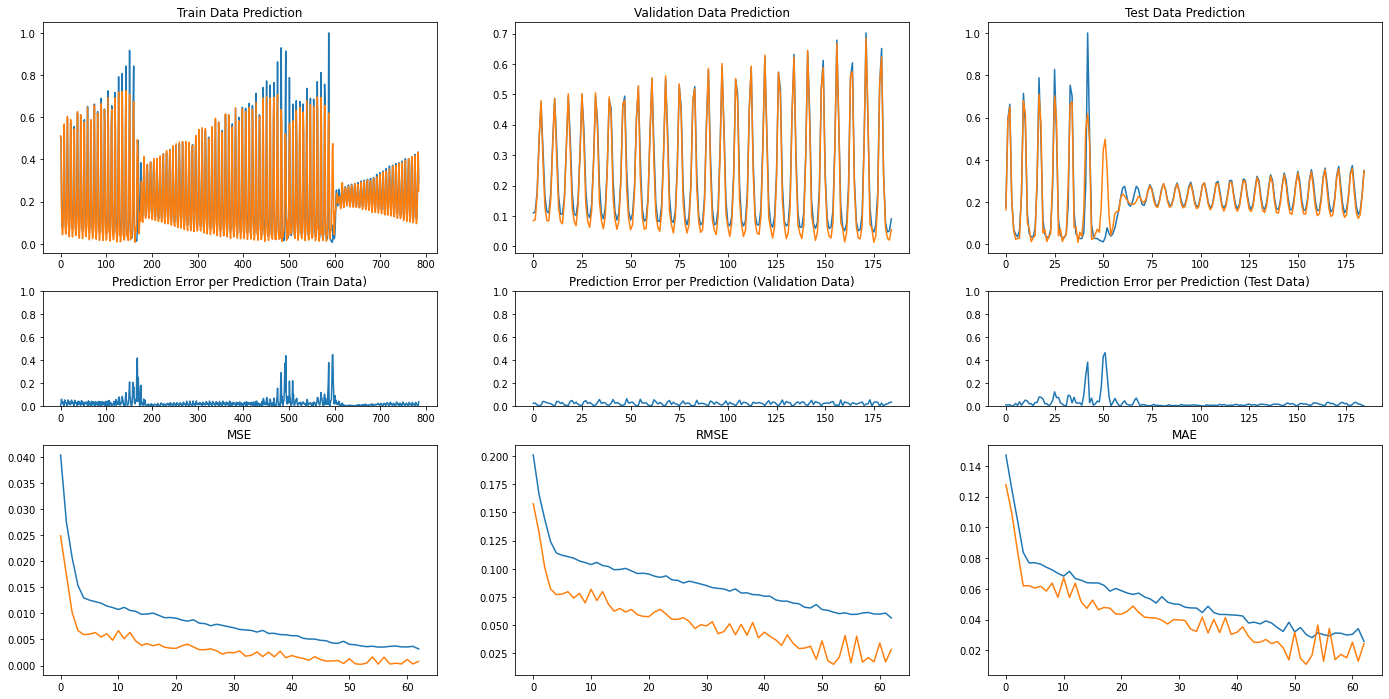

8/8 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048 - root_mean_squared_error: 0.0690 - mae: 0.0307
[0.004764495883136988, 0.004764495883136988, 0.06902533024549484, 0.030707361176609993]


In [43]:
#ts_test = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=b_size)
t2 = test_data.reshape(200,1)
ts_test = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)
validate_model(lstm_model,log_lstm_model,ts_train,ts_valid,ts_test)

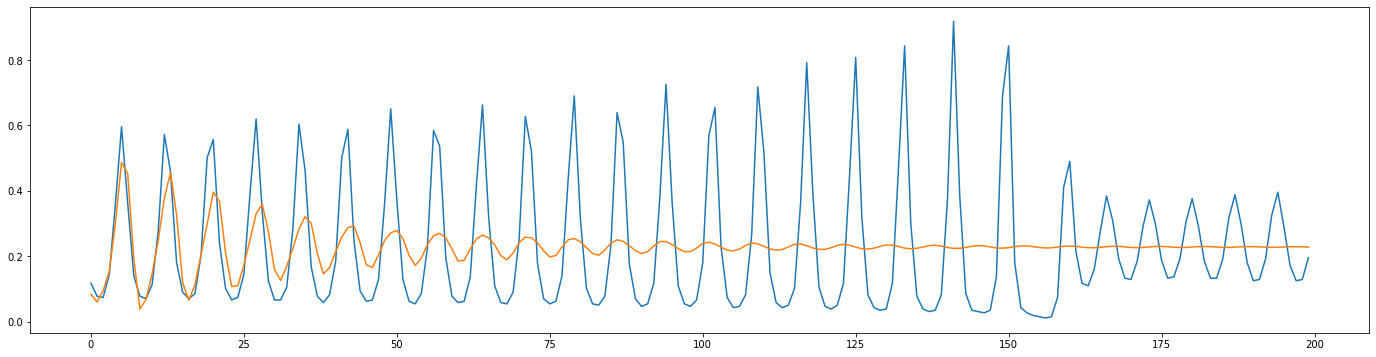

In [74]:
rec_input = ts_train[0][0][0].reshape(1,25)

rec_prediction = recursiv_prediction(lstm_model,data=rec_input,control_data=train_data,data_length=25)

# CNN


In [52]:
n_features = 1 #
n_input = 35 #@param {type:"slider", min:0, max:100, step:1}
b_size = 40 #@param {type:"slider", min:0, max:100, step:1}

MAX_EPOCHS = 100  #@param {type:"slider", min:0, max:100, step:1}

patience = 10  #@param {type:"slider", min:0, max:100, step:1}

CONV_WIDTH = 3 #@param {type:"slider", min:0, max:100, step:1}

t2 = train_data.reshape(800,1)
v2 = valid_data.reshape(200,1)

ts_train = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)
ts_valid = TimeseriesGenerator(v2, v2, length=n_input, batch_size=b_size)

conv_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_model = compile_model(conv_model)
log_conv_model = fit_model(conv_model,ts_train,ts_valid,patience)



Epoch 1/100
20/20 [==============================] - 1s 20ms/step - loss: 0.0395 - mse: 0.0395 - root_mean_squared_error: 0.1986 - mae: 0.1567 - val_loss: 0.0170 - val_mse: 0.0170 - val_root_mean_squared_error: 0.1302 - val_mae: 0.1039
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0176 - mse: 0.0176 - root_mean_squared_error: 0.1328 - mae: 0.0894 - val_loss: 0.0066 - val_mse: 0.0066 - val_root_mean_squared_error: 0.0811 - val_mae: 0.0622
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0131 - mse: 0.0131 - root_mean_squared_error: 0.1143 - mae: 0.0749 - val_loss: 0.0050 - val_mse: 0.0050 - val_root_mean_squared_error: 0.0709 - val_mae: 0.0505
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0104 - mse: 0.0104 - root_mean_squared_error: 0.1021 - mae: 0.0668 - val_loss: 0.0035 - val_mse: 0.0035 - val_root_mean_squared_error: 0.0592 - val_mae: 0.0459
Epoch 5/100
20/20 [==============================] - 0s 7ms

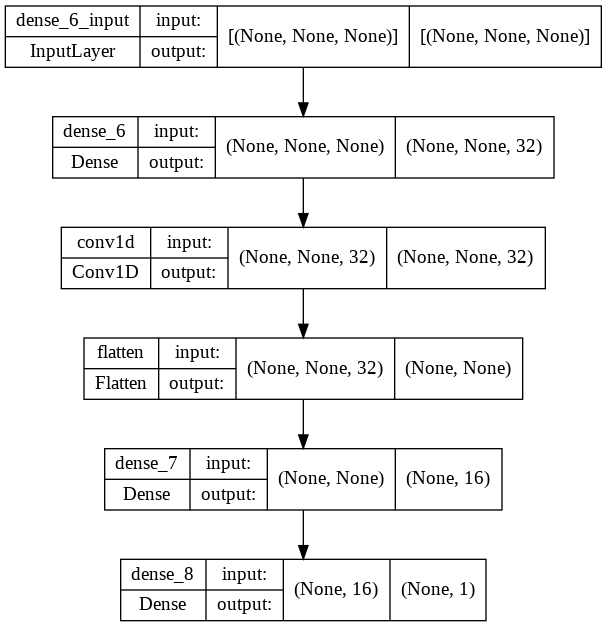

In [29]:
plot_model(conv_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

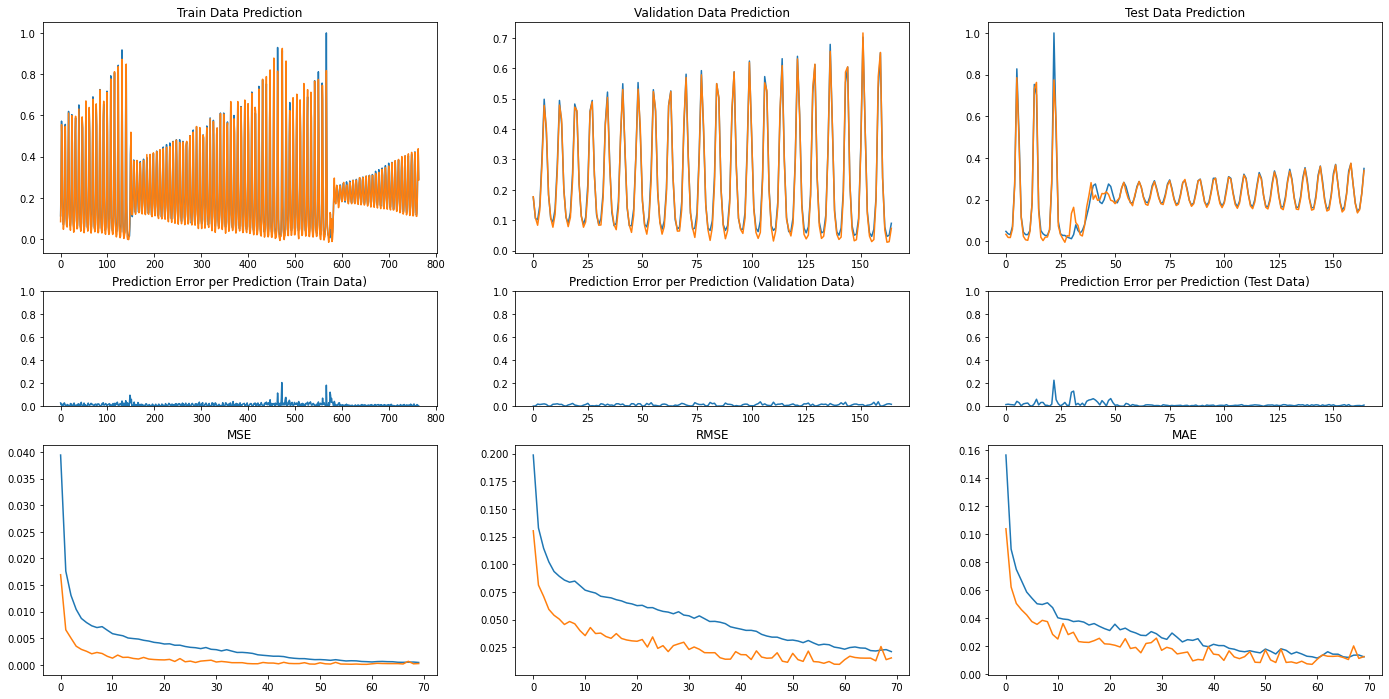

5/5 [==============================] - 0s 4ms/step - loss: 8.3083e-04 - mse: 8.3083e-04 - root_mean_squared_error: 0.0288 - mae: 0.0150
[0.000830826407764107, 0.000830826407764107, 0.028824059292674065, 0.014977852813899517]


In [53]:
t2 = test_data.reshape(200,1)
ts_test = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)

validate_model(conv_model,log_conv_model,ts_train,ts_valid,ts_test)

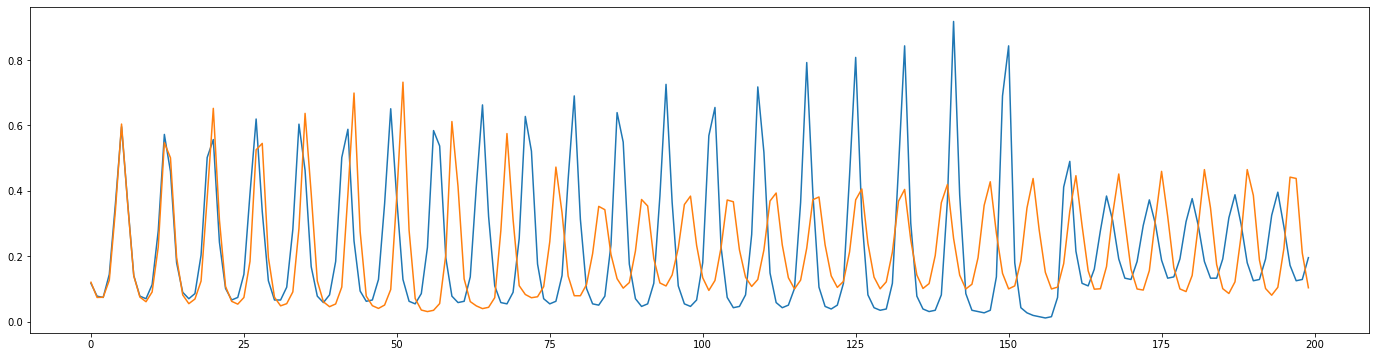

In [75]:
rec_prediction = recursiv_prediction(conv_model,ts_train[0][0][0].reshape(1,25,1),control_data=train_data,data_length=25)

#plt.plot(recursiv_prediction)

In [58]:
n_features = 1 #
n_input = 10 #@param {type:"slider", min:0, max:100, step:1}
b_size = 10 #@param {type:"slider", min:0, max:100, step:1}

MAX_EPOCHS = 100  #@param {type:"slider", min:0, max:100, step:1}

patience = 10  #@param {type:"slider", min:0, max:100, step:1}

CONV_WIDTH = 3 #@param {type:"slider", min:0, max:100, step:1}

t2 = train_data.reshape(800,1)
v2 = valid_data.reshape(200,1)

ts_train = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)
ts_valid = TimeseriesGenerator(v2, v2, length=n_input, batch_size=b_size)

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_model = compile_model(conv_model)
log_conv_model = fit_model(conv_model,ts_train,ts_valid,patience)

Epoch 1/100
79/79 [==============================] - 4s 14ms/step - loss: 0.0315 - mse: 0.0315 - root_mean_squared_error: 0.1775 - mae: 0.1333 - val_loss: 0.0151 - val_mse: 0.0151 - val_root_mean_squared_error: 0.1230 - val_mae: 0.1099
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0147 - mse: 0.0147 - root_mean_squared_error: 0.1214 - mae: 0.0863 - val_loss: 0.0066 - val_mse: 0.0066 - val_root_mean_squared_error: 0.0813 - val_mae: 0.0626
Epoch 3/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0125 - mse: 0.0125 - root_mean_squared_error: 0.1120 - mae: 0.0722 - val_loss: 0.0058 - val_mse: 0.0058 - val_root_mean_squared_error: 0.0758 - val_mae: 0.0536
Epoch 4/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0117 - mse: 0.0117 - root_mean_squared_error: 0.1082 - mae: 0.0676 - val_loss: 0.0039 - val_mse: 0.0039 - val_root_mean_squared_error: 0.0622 - val_mae: 0.0489
Epoch 5/100
79/79 [==============================] - 0s 6ms

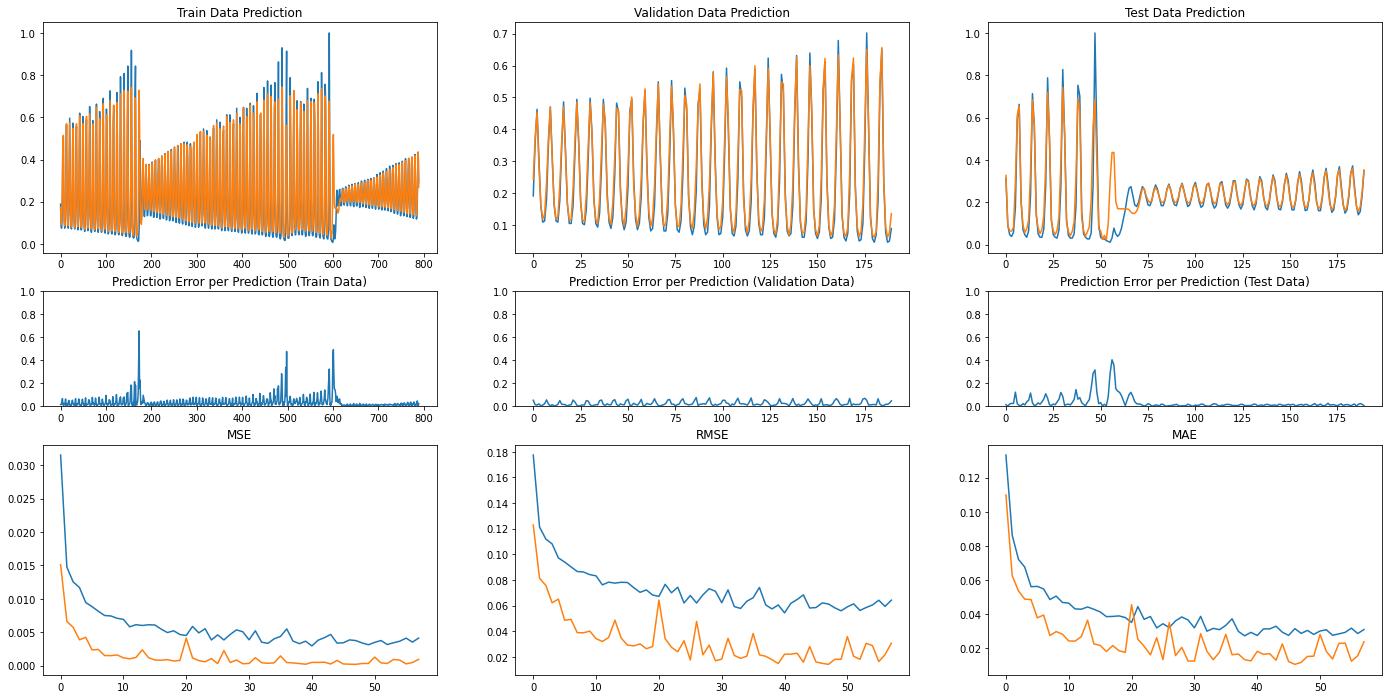

19/19 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045 - root_mean_squared_error: 0.0667 - mae: 0.0317
[0.004454947542399168, 0.004454947542399168, 0.06674539297819138, 0.031694453209638596]


In [59]:
t2 = test_data.reshape(200,1)
ts_test = TimeseriesGenerator(t2, t2, length=n_input, batch_size=b_size)

validate_model(conv_model,log_conv_model,ts_train,ts_valid,ts_test)

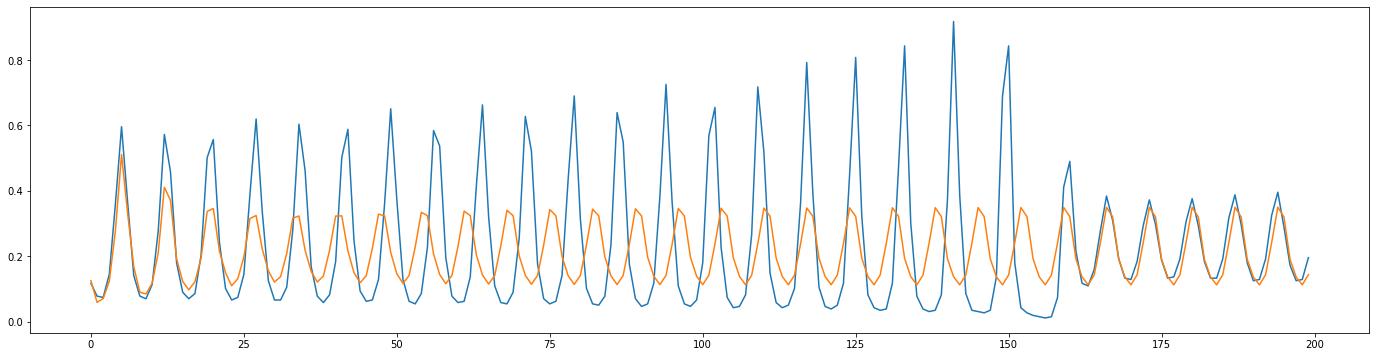

In [78]:
rec_prediction = recursiv_prediction(conv_model,ts_train[0][0][0].reshape(1,25,1),control_data=train_data,data_length=25)